
# Model-free control in action

This notebook uses Gymnasium environments to demonstrate model-free learning (agent interacts with an environment step-by-step):

- $\epsilon$-greedy exploration
- on-policy TD control: SARSA
- off-policy TD control: Q-learning
- function approximation and deep Q-learning (DQN) using Stable-Baselines3

We use:
- `CliffWalking-v1` for tabular SARSA vs Q-learning


In [2]:
#!pip install gymnasium[toy-text]
#!pip install stable-baselines3
#!pip install gymnasium[classic-control]

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython.display import Image, display
from dataclasses import dataclass

SEED = 0
random.seed(SEED)
np.random.seed(SEED)


## 1. Tabular control on `CliffWalking-v1`

Today’s experiment uses Gymnasium’s CliffWalking environment, a 4×12 grid like the one shown in the gif below. The task is straightforward: move the agent (the little character) from the start at [3,0] to the goal at [3,11] while avoiding the cliff along the bottom row. Each move costs a step, so the objective is to reach the goal in as few steps as possible without stepping into the cliff.

The reward the agent receives upon moving to different locations in the grid.

- -1: each time step
- -100: agent stepped into the cliff

[Link](https://gymnasium.farama.org/environments/toy_text/cliff_walking/)

Environment: `gymnasium.make("CliffWalking-v1")`

- state space: Discrete(48)
- action space: Discrete(4)
- reward: step cost, cliff penalty, terminal at goal

We will train and compare:
- SARSA (on-policy)
- Q-learning (off-policy)

Both use $\epsilon$-greedy exploration.


In [2]:
display(Image(url="https://gymnasium.farama.org/_images/cliff_walking.gif"))

In [3]:
import gymnasium as gym

env = gym.make('CliffWalking-v1', render_mode="rgb_array")

nS = env.observation_space.n
nA = env.action_space.n

env.observation_space
env.observation_space.sample()

2


### $\epsilon$-greedy policy

In [4]:
def epsilon_greedy(Q: np.ndarray, s: int, eps: float, nA: int) -> int:
    if random.random() < eps:
        return random.randrange(nA)
    return int(np.argmax(Q[s]))

def smooth(x, w=50):
    x = np.asarray(x, dtype=float)
    if len(x) < w:
        return x
    return np.convolve(x, np.ones(w)/w, mode="valid")

### SARSA (on-policy TD control)


1: Set initial $\epsilon$-greedy policy $\pi$ randomly, $t=0$, initial state $s_t=s_0$      
2: Take $a_t \sim \pi(s_t)$        
3: Observe $(r_t, s_{t+1})$         
4: loop         
5: $\quad$ Take action $a_{t+1} \sim \pi(s_{t+1})$ // Sample action from policy          
6: $\quad$ Observe $(r_{t+1}, s_{t+2})$     
7: $\quad$ Update $Q$ given $(s_t, a_t, r_t, s_{t+1}, a_{t+1})$:    $$
Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left[ r_{t+1} + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t) \right]$$
8: $\quad$ Perform policy improvement: The policy is updated every step, making it more greedy according to new Q-values.

$$\forall s \in S,\;\;
\pi(s) =
\begin{cases}
\arg\max\limits_a Q(s,a) & \text{with probability } 1 - \epsilon \\
\text{a random action}   & \text{with probability } \epsilon
\end{cases}$$


9: $\quad$ $t = t + 1$ , $\epsilon = \frac{1}{t}$             
10: end loop   



In [12]:
@dataclass
class SarsaArgs:
    learning_rate: float = 0.5      # alpha
    discount_factor: float = 1.0    # gamma
    max_epsilon: float = 1.0
    min_epsilon: float = 0.05
    epsilon_decay_rate: float = 0.001

class SarsaAgent:
    def __init__(self, n_actions: int, args: SarsaArgs):
        self.nA = n_actions
        self.args = args
        self.td_errors = []  

    def epsilon(self, episode: int) -> float:
        return self.args.min_epsilon + (self.args.max_epsilon - self.args.min_epsilon) * np.exp(
            -self.args.epsilon_decay_rate * episode
        )

    def act(self, Q: np.ndarray, s: int, eps: float) -> int:
        if random.random() < eps:
            return random.randrange(self.nA)
        return int(np.argmax(Q[s]))

    def update(self, Q: np.ndarray, s: int, a: int, r: float, s2: int, a2: int, done: bool) -> float:
       
        # SARSA target uses Q(s',a') from the behavior policy (on-policy)
        next_val = 0.0 if done else float(Q[s2, a2])
        td_target = r + self.args.discount_factor * next_val
        td_error = td_target - Q[s, a]
        Q[s, a] += self.args.learning_rate * td_error
        self.td_errors.append(td_error)
        return td_error


In [13]:
Q = np.zeros((nS, nA))
agent = SarsaAgent(n_actions=nA, args=SarsaArgs())

episodes = 5000
for ep in range(1, episodes + 1):
    eps = agent.epsilon(ep)

    s, _ = env.reset(seed=SEED + ep)
    a = agent.act(Q, s, eps)

    done = False
    while not done:
        s2, r, terminated, truncated, _ = env.step(a)
        done = terminated or truncated

        if done:
            # terminal: no next action; set a2=a (placeholder), update uses 0 for next_val
            agent.update(Q, s, a, r, s2, a, done=True)
            break

        a2 = agent.act(Q, s2, eps)          # on-policy next action
        agent.update(Q, s, a, r, s2, a2, done=False)

        s, a = s2, a2


In [14]:
Q

array([[-2.32850278e+01, -1.82422954e+01, -2.34623337e+01,
        -2.34125563e+01],
       [-2.33053425e+01, -1.47923679e+01, -2.54148261e+01,
        -2.49042620e+01],
       [-1.84840673e+01, -1.32482198e+01, -2.12672215e+01,
        -2.31104452e+01],
       [-2.04788330e+01, -1.16182512e+01, -2.39831331e+01,
        -1.90795862e+01],
       [-1.56244364e+01, -1.02033425e+01, -1.88178663e+01,
        -1.88945466e+01],
       [-1.39375180e+01, -9.04380456e+00, -2.00154700e+01,
        -1.80349607e+01],
       [-1.09047143e+01, -8.00753312e+00, -1.34419907e+01,
        -1.54989295e+01],
       [-9.75130962e+00, -7.00138719e+00, -1.08764492e+01,
        -1.23176412e+01],
       [-9.33788222e+00, -6.00016653e+00, -1.10843970e+01,
        -1.09819517e+01],
       [-8.93410343e+00, -6.34778586e+00, -9.19232075e+00,
        -8.18717160e+00],
       [-6.86665488e+00, -4.00000011e+00, -6.86196349e+00,
        -9.04334734e+00],
       [-5.54594133e+00, -6.30562623e+00, -3.00000000e+00,
      

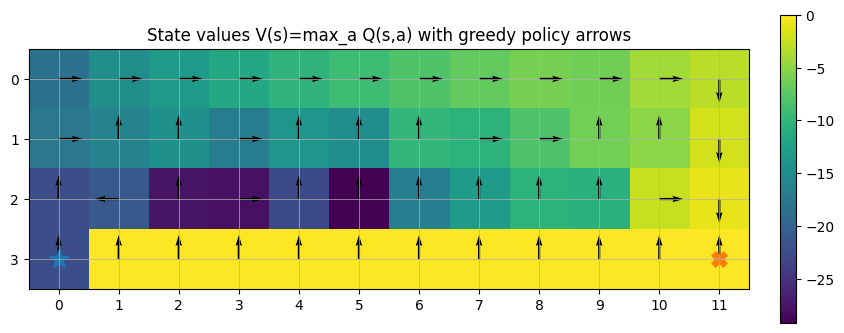

In [15]:
def plot_value_and_policy(env, Q):
    nS, nA = Q.shape
    nrow, ncol = 4, 12

    V = Q.max(axis=1).reshape(nrow, ncol)
    pi = Q.argmax(axis=1).reshape(nrow, ncol)

    fig, ax = plt.subplots(figsize=(10, 4))
    im = ax.imshow(V, origin="upper")
    plt.colorbar(im, ax=ax, fraction=0.03, pad=0.04)
    ax.set_title("State values V(s)=max_a Q(s,a) with greedy policy arrows")

    # arrows: (dx, dy) in grid coords (col, row)
    dx = np.zeros((nrow, ncol))
    dy = np.zeros((nrow, ncol))
    # action: 0=up,1=right,2=down,3=left
    dx[pi == 1] =  1
    dx[pi == 3] = -1
    dy[pi == 2] =  1
    dy[pi == 0] = -1

    X, Y = np.meshgrid(np.arange(ncol), np.arange(nrow))
    ax.quiver(X, Y, dx, dy, angles="xy", scale_units="xy", scale=2.5, width=0.003)

    # mark default start/goal for classic CliffWalking
    start_rc = (nrow - 1, 0)
    goal_rc  = (nrow - 1, ncol - 1)
    ax.scatter([start_rc[1]], [start_rc[0]], marker="*", s=200)
    ax.scatter([goal_rc[1]],  [goal_rc[0]],  marker="X", s=120)

    ax.set_xticks(np.arange(ncol))
    ax.set_yticks(np.arange(nrow))
    ax.grid(which="both", linewidth=0.5)
    plt.show()

plot_value_and_policy(env, Q)


In [16]:
import gymnasium as gym

def rollout_greedy(env_name, Q, seed=0, max_steps=500):
    env_eval = gym.make(env_name)  # no render needed
    nS, nA = Q.shape
    nrow, ncol = 4, 12

    s, _ = env_eval.reset(seed=seed)
    path = [s]
    total_reward = 0.0

    for _ in range(max_steps):
        a = int(np.argmax(Q[s]))
        s2, r, terminated, truncated, _ = env_eval.step(a)
        total_reward += r
        path.append(s2)
        s = s2
        if terminated or truncated:
            break

    env_eval.close()
    return path, total_reward

def plot_path_on_grid(env, Q, path):
    nS, _ = Q.shape
    nrow, ncol = 4, 12

    V = Q.max(axis=1).reshape(nrow, ncol)

    coords = np.array([s_to_rc(s, ncol) for s in path])  # (row,col)
    rows, cols = coords[:, 0], coords[:, 1]

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.imshow(V, origin="upper")
    ax.plot(cols, rows, linewidth=2)  # path line
    ax.scatter([cols[0]], [rows[0]], marker="*", s=200)  # start
    ax.scatter([cols[-1]], [rows[-1]], marker="X", s=120)  # end

    ax.set_title("Greedy rollout path (start=* , end=X) on value background")
    ax.set_xticks(np.arange(ncol))
    ax.set_yticks(np.arange(nrow))
    ax.grid(which="both", linewidth=0.5)
    plt.show()

path, ret = rollout_greedy("CliffWalking-v1", Q, seed=123)
print("Greedy rollout return:", ret, "steps:", len(path)-1)
plot_path_on_grid(env, Q, path)


Greedy rollout return: -17.0 steps: 17


NameError: name 's_to_rc' is not defined